In [6]:
import numpy as np
import torch, torchvision
import matplotlib.pyplot as plt
%matplotlib widget

# Homework 3

Homework 3 will cover materials from chapter 5 (CNNs), 6 (CNNs for classification), and 7 (CNN for segmentation).

Ideally, computational, analytical, and written parts can be submitted as part of this jupyter notebook.

Homework should be submitted by email, to dtward@mednet.ucla.edu.

Coding parts can be submitted as part of the notebook, using as many cells as is convenient.

Analytical parts should be submitted with math rendered using Latex in markdown cells, using as many cells as is convenient.

Written parts can use markdown cells.

If you do not know how to type equations in Latex, and cannot work out enough of the basics using the equations provided here, please email me and we'll work something out.

There is lots of exposition in this homework assignment.  All the problems that need to be solved are labeled with the the title "Problem".

Homework will be due on Monday March 11 (two weeks from today).

In homework 3, 90% of your grade will be based on the quality and accuracy of the work you do in this notebook.  10% of your grade will be based on how well your CNNs perform relative to the other students in the class.

## Part 1, data augmentation

### 1.1 Our dataset

We will use the dermaMNIST dataset for this problem and the following one.


In [51]:
from medmnist import DermaMNIST
dataset_train = DermaMNIST(split='train',download=True,transform=torchvision.transforms.ToTensor())
dataset_val = DermaMNIST(split='val',download=True,transform=torchvision.transforms.ToTensor())
dataset_test = DermaMNIST(split='test',download=True,transform=torchvision.transforms.ToTensor())

Text(0.5, 1.0, 'label [5]')

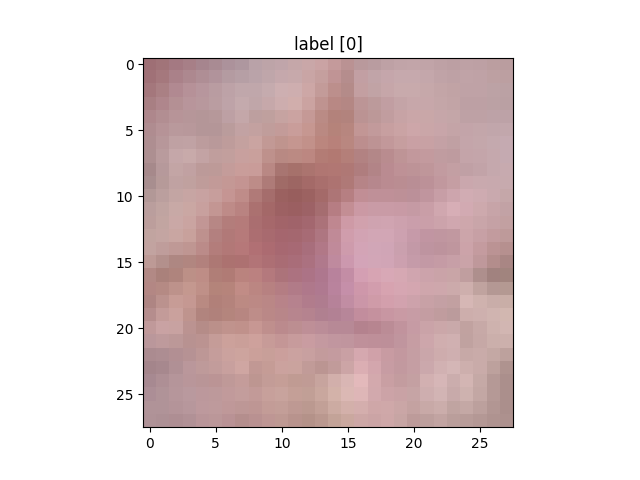

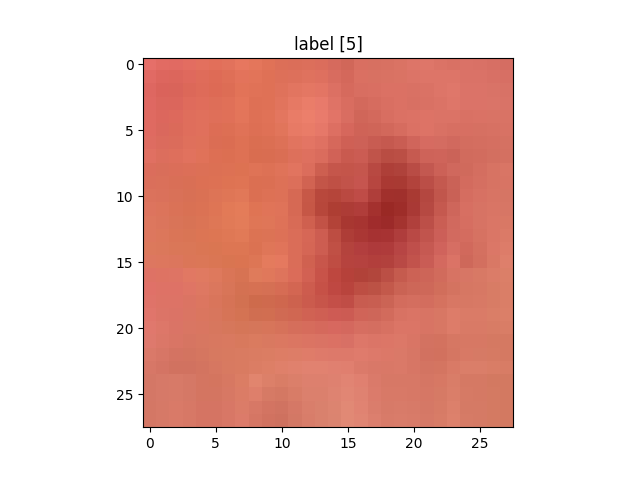

In [52]:
I,l = dataset_train[0]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

I,l = dataset_train[1]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

### 1.2 a dataset randomizer

Below we provide some code to apply random transformations to our images or labels, and visualize some examples.

We show 5 different label-preserving transformations of the same image.

Note that there are two empty sections that need to be filled in, which are the next two problems.

In [53]:
def interpn(x,I,Xs,**kwargs):
    ''' A utility function based around torch's grid sample function
    but with interface the same as numpy's interpn'''
    # scale sample points to -1 to 1
    x0 = torch.stack([x[0][0],x[1][0]])
    x1 = torch.stack([x[0][-1],x[1][-1]])
    Xs = Xs - x0
    Xs = Xs / (x1 - x0)
    Xs = Xs*2-1
    
    # add and remove a batch dimension if necessary
    if I.ndim == 3:        
        Is = torch.nn.functional.grid_sample(I[None],Xs[None].flip(-1),align_corners=True,**kwargs)[0]
    else:
        Is = torch.nn.functional.grid_sample(I,Xs.flip(-1),align_corners=True,**kwargs)
    return Is

In [54]:
class RandomizedDataset(torch.utils.data.Dataset):
    ''' A class to apply randomizations to your dataset'''
    def __init__(self,dataset,
                 random_rotate=False,
                 random_reflect=False, 
                 random_affine=False,
                 random_deformation=False,
                 random_window_level=False,
                 random_gamma=False,
                 random_noise=False,
                ):
        # set the dataset to a member variable
        self.dataset = dataset
        
        
        
        # set the options to apply randomizations to member variables
        self.random_rotate = random_rotate
        self.random_reflect = random_reflect
        self.random_affine = random_affine
        self.random_deformation = random_deformation
        self.random_window_level = random_window_level
        self.random_gamma = random_gamma
        self.random_noise = random_noise
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,i):
        I,l = self.dataset[i]
        # check if the labels are segmentation labels
        # if they are, we will have to apply the same transformations
        # to the labels and the images
        if l.ndim == 1:
            l_is_image = False
        else:
            l_is_image = True
        
        # apply geometric transformations
        # note that we will need to apply the same transform to the image and segmentation
        if self.random_rotate:
            nrot = np.random.randint(4)
            I = torch.rot90(I,nrot,dims=(-1,-2))
            if l_is_image:
                l = torch.rot90(l,nrot,dims=(-1,-2))
        
        if self.random_reflect:
            if np.random.rand()>0.5:
                I = torch.flip(I,dims=(-1,-2))
                if l_is_image:
                    l = torch.flip(l,dims=(-1,-2))
        # get zero centered pixel locations
        x0 = torch.arange(I.shape[-2]) - (I.shape[-2]-1)/2
        x1 = torch.arange(I.shape[-1]) - (I.shape[-1]-1)/2
        X = torch.stack(torch.meshgrid(x0,x1,indexing='ij'),-1)        
        if self.random_affine:
            
            # a random matrix is added to identity for the linear part
            L = torch.eye(2) + torch.randn(2,2)*0.1
            # a random translation with standard deviation of 3 pixels is added to the tanslation
            T = torch.randn(2,1)*3
            # concatenate them
            A = torch.concatenate((L,T),-1)
            A = torch.concatenate((A,torch.tensor([[0.0,0.0,1.0]])),-2)
            Ai = torch.linalg.inv(A)
            # get sample points
            Xs = (Ai[:2,:2]@X[...,None])[...,0] + Ai[:2,-1]
            I = interpn([x0,x1],I,Xs,padding_mode='border')
            if l_is_image:                
                # note we use 'nearest neighbor' interpolation for labels
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
        if self.random_deformation:
            # YOUR WORK HERE
            # 
            # 1. 
            # create 2 28x28 torch tensors which will represent the row and col components of your displacement fields
            height, width = I.shape[-2:]
            #             
            p0 =  torch.randn(height, width)
            p1 =  torch.randn(height, width)       
            # 
            # 2. 
            # multiply them by whatever standard deviation you choose, this will relate to the magnitude of displacement
        
            p0 *= 1.75
            p1 *= 1.75  
                        
            # 3. 
            # blur it with a gaussian kernel of whatever width you choose
            # I suggest using the function:  torchvision.transforms.functional.gaussian_blur            
            # but there are other choices we have covered in class        
            # if you use this choice you will have to add a leading dimension to the input, and remove it from the output
            # example of adding and removing a leading dimension:
            # * blurred_image = blur( my_image[None])[0]
            
            p0 = torchvision.transforms.functional.gaussian_blur(p0[None], 5)[0]
            p1 = torchvision.transforms.functional.gaussian_blur(p1[None], 5)[0]
            
            # 4. 
            # stack p0 and p1 into a 28x28x2 array and            
            # interpolate your images at X - your_random_displacement_field
            # Xs = X - torch.stack((p0,p1))
            
            Xs = X - torch.stack((p0, p1), dim = -1)
            I = interpn([x0,x1],I,Xs,padding_mode='border')
            if l_is_image:                
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
            
            # see the above affine transform for any help with interpolation
            # 
            # make sure the std and kernel size you choose lead to realistic images
            pass
                
            
            
            
        
        # apply pixel intsenity transforations
        # these will be applied only to the image
        # and not to the labels
        if self.random_window_level:
            # YOUR WORK HERE!
            # choose a vmin randomly between 0 and 0.25
            vmin = torch.rand(1).item() * 0.25
            # choose a vmax randomly between 0.75 and 1
            vmax = 0.75 + torch.rand(1).item() * 0.25

            # rescale the image so that vmin maps to 0, and vmax maps to 1
            I = (I - vmin) / (vmax - vmin)

            # clip any pixels less than 0 to the value 0
            # clip any pixels greater than 1 to the value 1
            I = torch.clamp(I, 0, 1)
            pass
            
        if self.random_gamma:            
            gamma_ = (np.random.rand()*2-1) # between -1 and 1
            gamma = 2.0**gamma_ # between 0.5 and 2.0
            I = I**gamma
            
        if self.random_noise:
            frac = 0.05
            I = I*(1-frac) + torch.rand(*I.shape)*frac
        return I,l
        
        
    

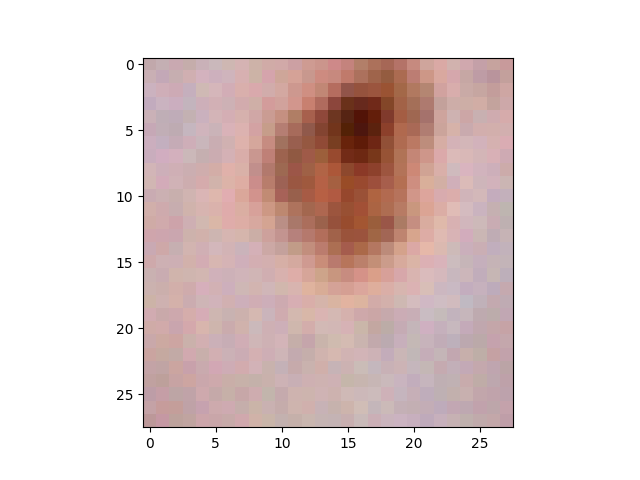

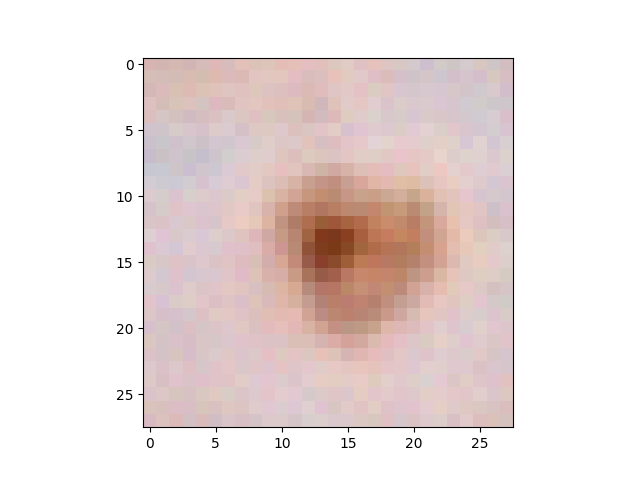

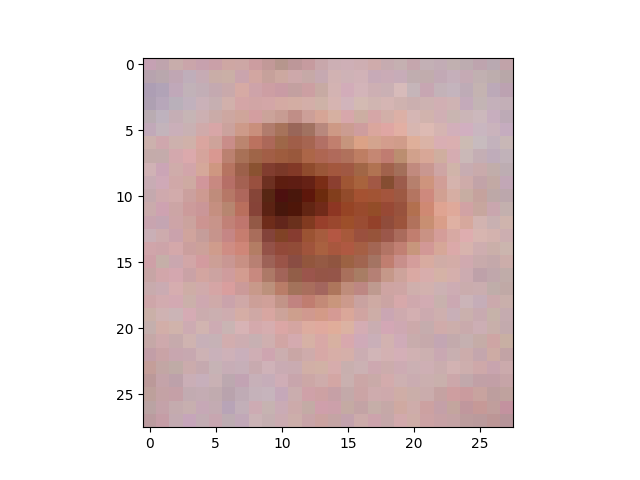

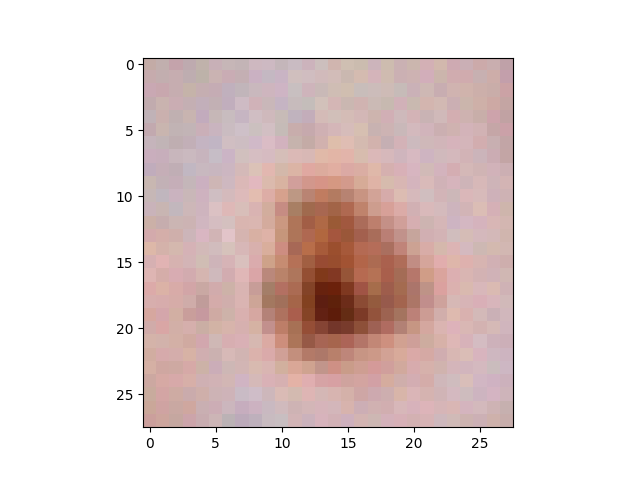

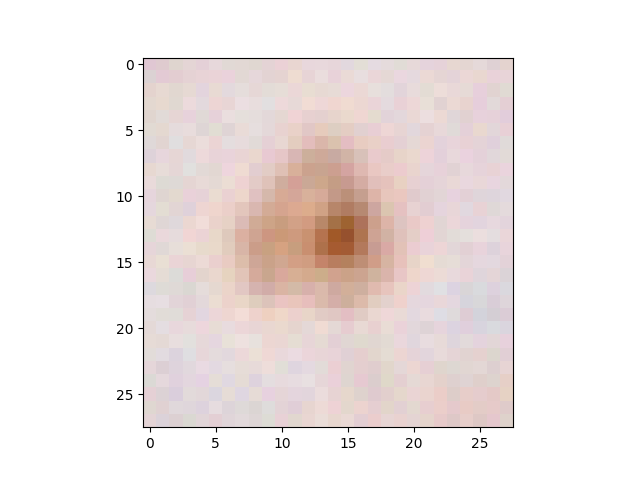

In [55]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_rotate=True,
    random_reflect=True,    
    random_affine=True,        
    random_noise=True,
    random_gamma=True,    
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.3 

Complete the code in the random_window_level section.  Show 5 different random transformations of the same image using the code below.


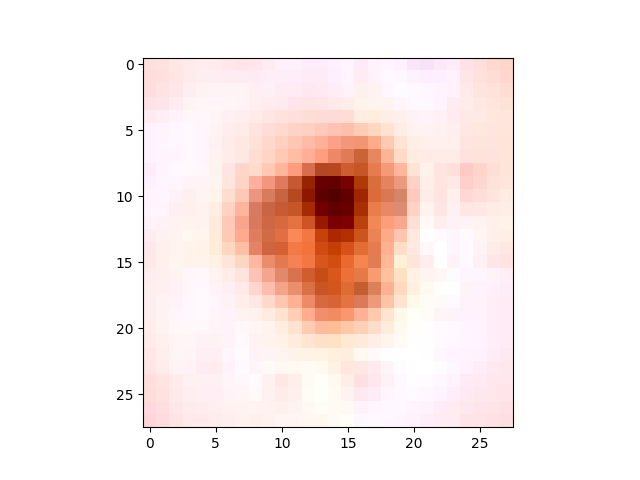

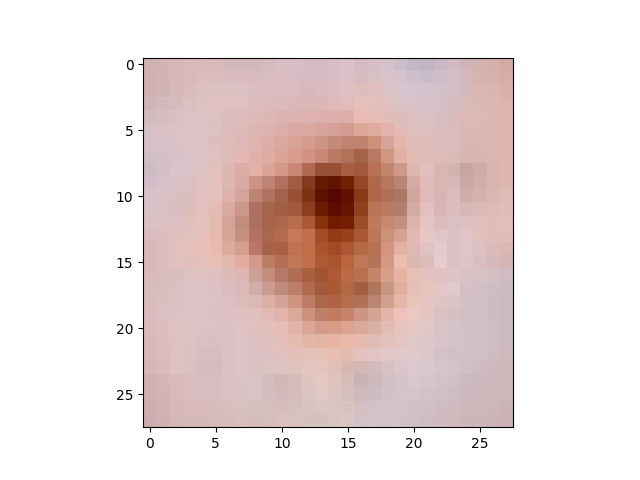

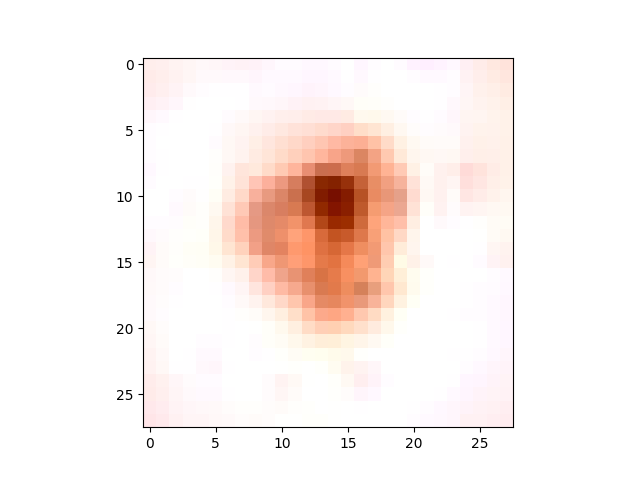

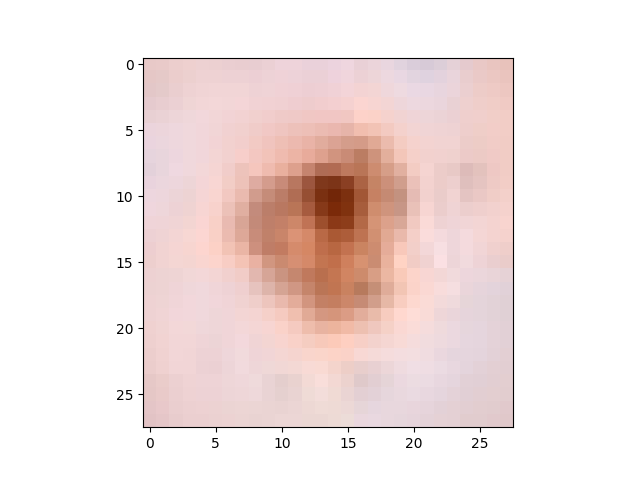

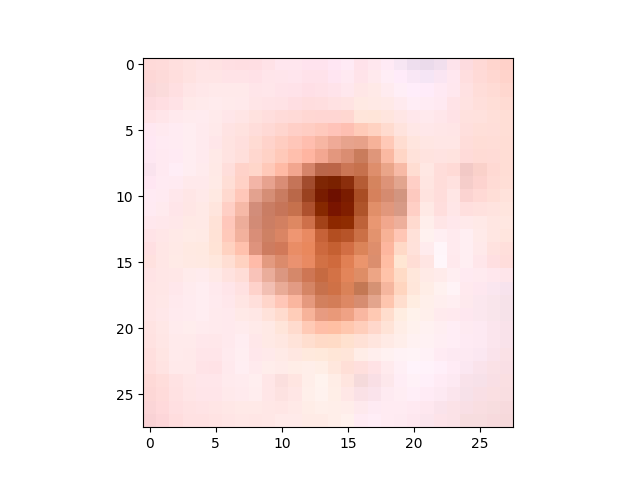

In [56]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_window_level=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.4

Complete the code in the random deformation section. Show 5 different random transformations of the same image using the code below.

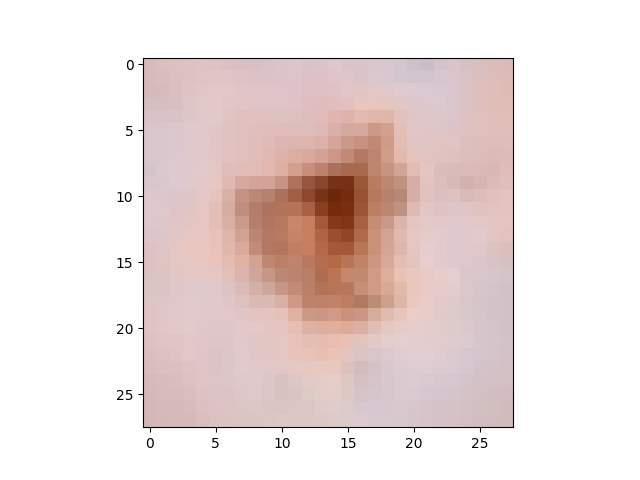

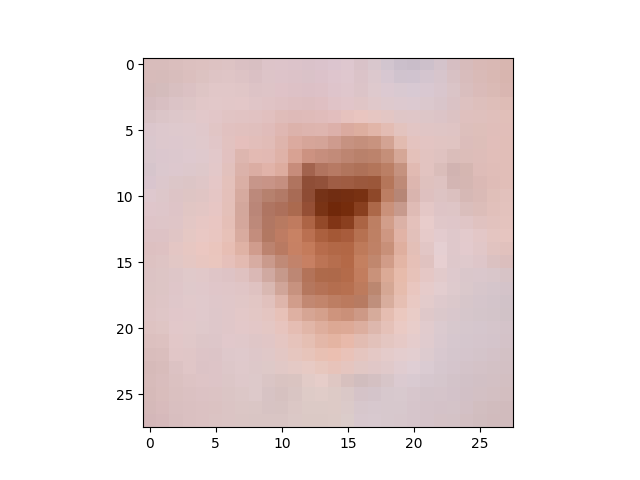

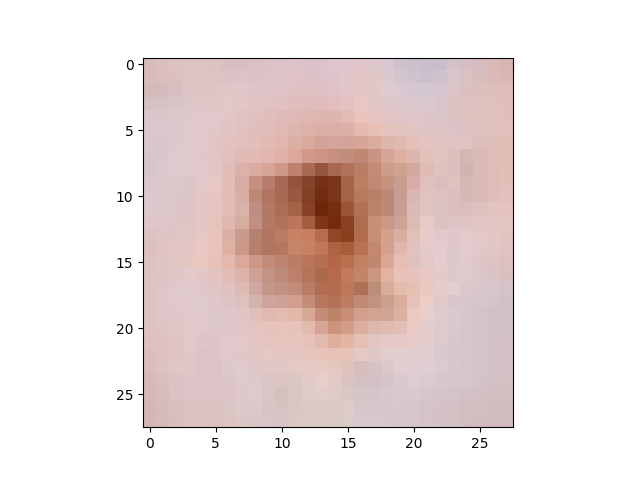

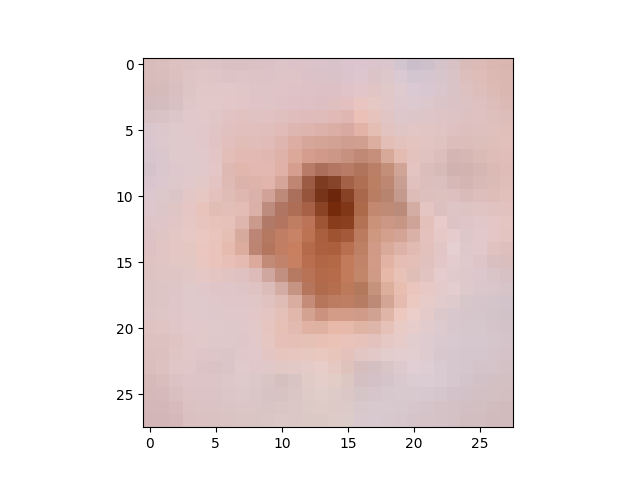

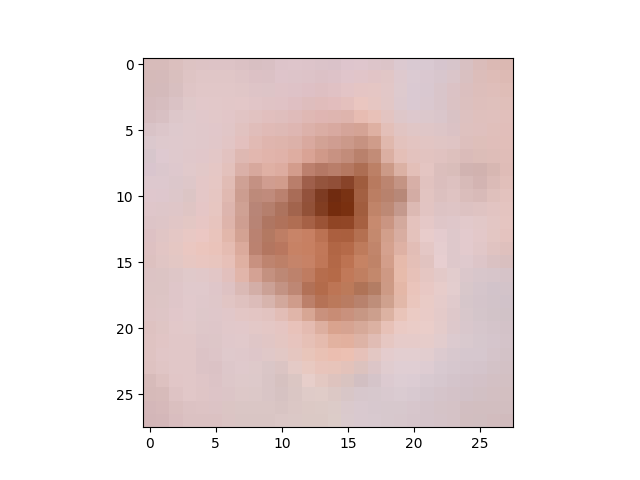

In [57]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_deformation=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

## Part 2, image classification

### Problem 2.1

Design at least two CNNs for classifying the DermaMNIST dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

Train them on the training set (for however long you want), and test their accuracy on the validation set.

Choose the best performing model on the validation set, and report its accuracy on the test set.

I will rerun your notebook, and evaluate perforance in terms of accuracy on a random subset of the test set.  The random subset will be the same for all students.  5% of your grade (out of 100%) on this assignment will be based on your accuracy relative to the other students.  The student with the highest accuracy will recieve 5%. The student with the lowest accuracy will recieve 0%.  The others will vary linearly between these extremes.

In [58]:
device = 'cuda:0'

dataset_train = DermaMNIST(split='train',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)
dataset_val = DermaMNIST(split='val',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)
dataset_test = DermaMNIST(split='test',download=True,transform=torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor()
])
)
dataloader = torch.utils.data.DataLoader(dataset_train,batch_size=8, shuffle = True)
dataloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=8, shuffle = True)
dataloader_val= torch.utils.data.DataLoader(dataset_val,batch_size=8, shuffle = True)


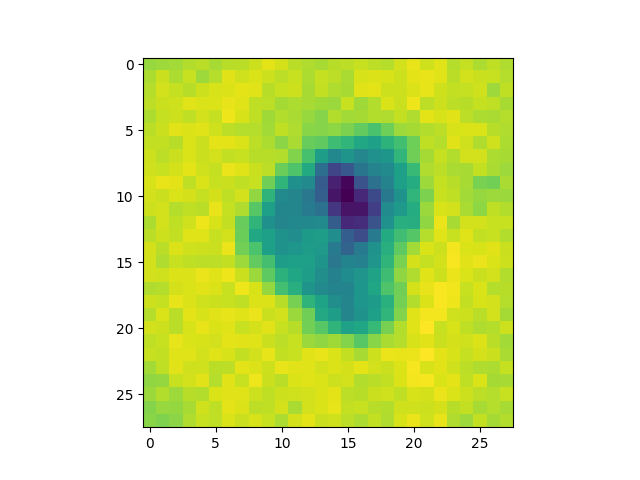

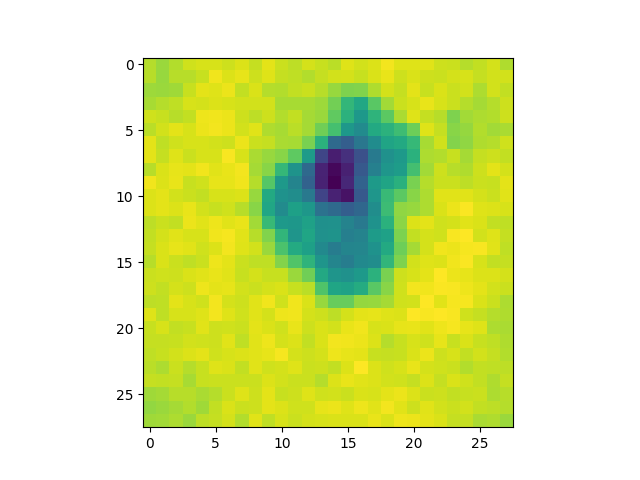

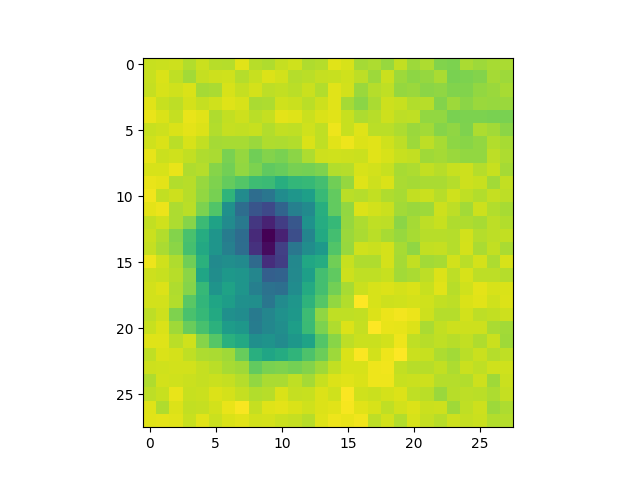

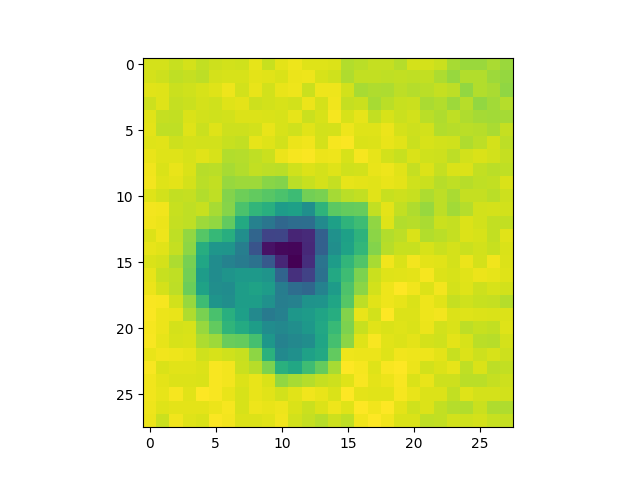

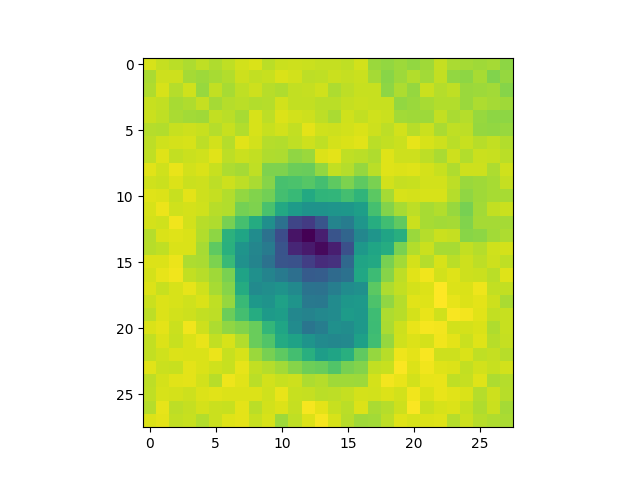

In [59]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_deformation=True,
    random_affine=True,
    random_window_level=True,
    random_noise=True,
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))
    
dataloader_train_randomized = torch.utils.data.DataLoader(dataset_train_randomized,batch_size=8, shuffle = True)

In [ ]:
class Model1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        channels0 = 8
        kernel_size = 3
        stride = 2
        padding = 1
        self.c0 = torch.nn.Conv2d(1,channels0,kernel_size,1, padding)
        self.c1 = torch.nn.Conv2d(channels0,channels0*2,kernel_size,stride, padding)
        self.c2 = torch.nn.Conv2d(channels0*2,channels0*4,kernel_size,stride, padding)
        self.c3 = torch.nn.Conv2d(channels0*4,8,kernel_size,stride, padding) # note 8 not 1, this is the only change
        
    def forward(self,x):
        # convolutions and nonlinearities
        x = self.c0(x)
        x = torch.relu(x)
        
        x = self.c1(x)
        x = torch.relu(x)
        
        x = self.c2(x)
        x = torch.relu(x)
        
        x = self.c3(x)
        
        
        # average pool so we get one pmf        
        x = torch.mean(x,(-1,-2))
        
        return x

In [71]:
model1 = Model1()
model1 = model1.to(device)

In [72]:
nparam = 0
for p in model1.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

8200 parameters


In [73]:
optimizer = torch.optim.Adam(model1.parameters(),lr=1e-3)

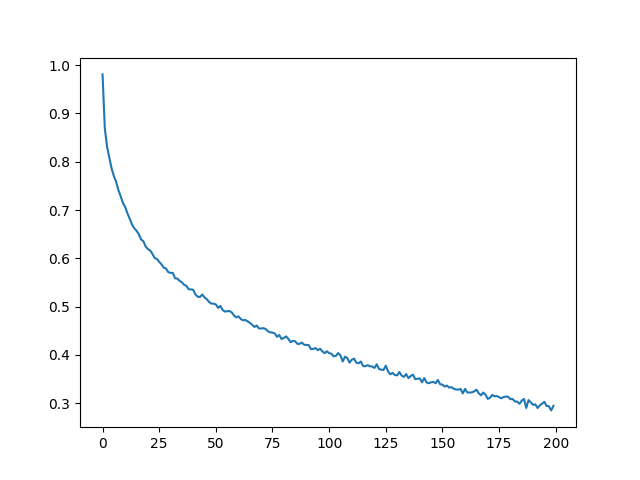

In [90]:
nepochs = 200
Esave = []
model1 = model1.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model1(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataloader))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    

In [91]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4train = correct/count
print(f'accuracy train is {accuracy4train}')

accuracy train is 0.9145140573712002


In [92]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4 = correct/count
print(f'accuracy is {accuracy4}')

accuracy is 0.628428927680798


In [93]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = model1(x)
        c = torch.argmax(out,-1)         
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyresval = correct/count
print(f'val accuracy is {accuracyresval}')

val accuracy is 0.6211365902293121


In [94]:
torch.save(model1.state_dict(), r"C:\Users\WINDOWS\Desktop\DSB207\model1.pt")

In [65]:
model1.load_state_dict(torch.load(r'C:\Users\WINDOWS\Desktop\DSB207\model1.pt'))

<All keys matched successfully>

In [31]:
class ModelCustom(torch.nn.Module):
    def __init__(self):
        super().__init__()

        channels0 = 8
        kernel_size = 3
        stride = 2
        padding = 1

        self.c0 = torch.nn.Conv2d(1, channels0, kernel_size, 1, padding)
        self.b0 = torch.nn.BatchNorm2d(channels0)
        self.c0a = torch.nn.Conv2d(channels0, channels0, kernel_size, 1, padding)
        self.b0a = torch.nn.BatchNorm2d(channels0)
        self.c0b = torch.nn.Conv2d(channels0, channels0, kernel_size, 1, padding)
        self.b0b = torch.nn.BatchNorm2d(channels0)

        self.c1 = torch.nn.Conv2d(channels0, channels0 * 2, kernel_size, stride, padding)
        self.b1 = torch.nn.BatchNorm2d(channels0 * 2)
        self.c1a = torch.nn.Conv2d(channels0 * 2, channels0 * 2, kernel_size, 1, padding)
        self.b1a = torch.nn.BatchNorm2d(channels0 * 2)
        self.c1b = torch.nn.Conv2d(channels0 * 2, channels0 * 2, kernel_size, 1, padding)
        self.b1b = torch.nn.BatchNorm2d(channels0 * 2)
        
        self.c2 = torch.nn.Conv2d(channels0 * 2, channels0 * 4, kernel_size, stride, padding)
        self.b2 = torch.nn.BatchNorm2d(channels0 * 4)
        self.c2a = torch.nn.Conv2d(channels0 * 4, channels0 * 4, kernel_size, 1, padding)
        self.b2a = torch.nn.BatchNorm2d(channels0 * 4)
        self.c2b = torch.nn.Conv2d(channels0 * 4, channels0 * 4, kernel_size, 1, padding)
        self.b2b = torch.nn.BatchNorm2d(channels0 * 4)

        self.c3 = torch.nn.Conv2d(channels0 * 4, channels0 * 8, kernel_size, stride, padding)
        self.b3 = torch.nn.BatchNorm2d(channels0 * 8)
        self.c3a = torch.nn.Conv2d(channels0 * 8, channels0 * 8, kernel_size, 1, padding)
        self.b3a = torch.nn.BatchNorm2d(channels0 * 8)
        self.c3b = torch.nn.Conv2d(channels0 * 8, channels0 * 8, kernel_size, 1, padding)
        self.b3b = torch.nn.BatchNorm2d(channels0 * 8)
        self.c3c = torch.nn.Conv2d(channels0 * 8, 8, kernel_size, 1, padding)

    def forward(self, x):
        x0 = x.clone()
        x = self.c0(x)
        x = self.b0(x)
        x = torch.relu(x)
        x = torch.concatenate((x[:, :1] + x0, x[:, 1:]), 1)

        x0 = x.clone()
        x = self.c0a(x)
        x = self.b0a(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c0b(x)
        x = self.b0b(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c1(x)
        x = self.b1(x)
        x = torch.relu(x)
        x = torch.concatenate((x[:, :x.shape[1] // 2] + x0[:, :, ::2, ::2], x[:, x.shape[1] // 2:]), 1)

        x0 = x.clone()
        x = self.c1a(x)
        x = self.b1a(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c1b(x)
        x = self.b1b(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c2(x)
        x = self.b2(x)
        x = torch.relu(x)
        x = torch.concatenate((x[:, :x.shape[1] // 2] + x0[:, :, ::2, ::2], x[:, x.shape[1] // 2:]), 1)

        x0 = x.clone()
        x = self.c2a(x)
        x = self.b2a(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c2b(x)
        x = self.b2b(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c3(x)
        x = self.b3(x)
        x = torch.relu(x)
        x = torch.concatenate((x[:, :x.shape[1] // 2] + x0[:, :, ::2, ::2], x[:, x.shape[1] // 2:]), 1)

        x0 = x.clone()
        x = self.c3a(x)
        x = self.b3a(x)
        x = torch.relu(x)
        x = x + x0

        x0 = x.clone()
        x = self.c3b(x)
        x = self.b3b(x)
        x = torch.relu(x)
        x = x + x0

        x = self.c3c(x)

         # average pool so we get one number
        x = torch.mean(x, (-1, -2))

        return x

In [32]:
modelcustom = ModelCustom()
modelcustom = modelcustom.to(device)

In [33]:
optimizer = torch.optim.Adam(modelcustom.parameters(), lr=1e-3, weight_decay=1e-4)  # increase weight_decay

In [34]:
nparam = 0
for p in modelcustom.parameters():
    nparam += p.numel()
print(f'{nparam} parameters')

127880 parameters


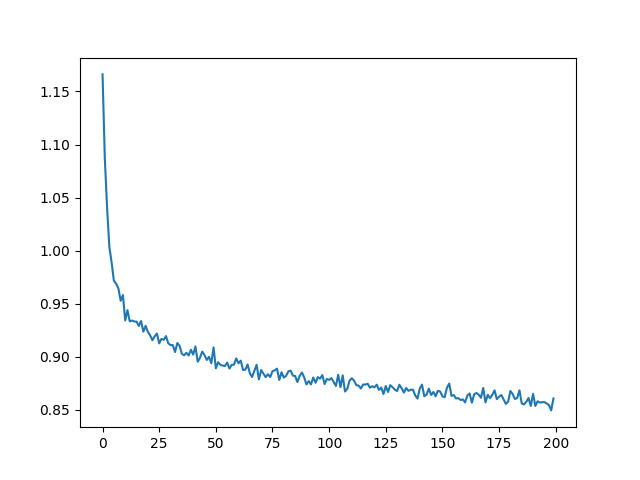

In [ ]:
nepochs = 200
Esave = []
modelcustom = modelcustom.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):
       
        
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()        
        
        # forward
        out = modelcustom(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataloader))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

In [44]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = modelcustom(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4train = correct/count
print(f'accuracy train is {accuracy4train}')

accuracy train is 0.9307835022120736


In [45]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_test:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = modelcustom(x)
        c = torch.argmax(out,-1) # need to check this is the right size
        
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracy4 = correct/count
print(f'accuracy is {accuracy4}')

accuracy is 0.6478802992518703


In [46]:
with torch.no_grad():
    count = 0
    correct = 0
    for x,l in dataloader_val:
        x = x.to(device)
        l = l.to(device)

        # forward
        out = modelcustom(x)
        c = torch.argmax(out,-1)         
        
        
        count += x.shape[0]
        correct += torch.sum(c==l.squeeze()).item()
accuracyresval = correct/count
print(f'val accuracy is {accuracyresval}')

val accuracy is 0.6590229312063809


In [ ]:
torch.save(modelcustom.state_dict(), r"C:\Users\WINDOWS\Desktop\DSB207\modelcustom.pt")

In [35]:
modelcustom.load_state_dict(torch.load(r'C:\Users\WINDOWS\Desktop\DSB207\modelcustom.pt'))

<All keys matched successfully>

My best is 0.931 training accuracy, 0.6600 testing accuracy, and 0.6600 validation accuracy with my second model

## Part 3, image segmentation

For this problem we will use the lung segmentation dataset already shared in class.

In [7]:
x = np.load('images_x.npy')
y = np.load('segmentations_y.npy')

In [8]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self,split='train'):
        if split not in ['train','test','val']:
            raise Exception(f'split must be train test or val, but you input {split}')
        self.split = split
        if split == 'train':
            self.x = x[:-20].reshape((-1,1,64,64,))
            self.y = y[:-20].reshape((-1,1,64,64,))
        elif split == 'test':
            self.x = x[-10:].reshape((-1,1,64,64,))
            self.y = y[-10:].reshape((-1,1,64,64,))
        elif split == 'val':
            self.x = x[-20:-10].reshape((-1,1,64,64,))
            self.y = y[-20:-10].reshape((-1,1,64,64,))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)

In [9]:
dataset_lung_train = LungDataset(split='train')
dataset_lung_test = LungDataset(split='test')
dataset_lung_val = LungDataset(split='val')
I,l = dataset_lung_train[0]
dataloader_lung = torch.utils.data.DataLoader(dataset_lung_train,batch_size=8)
dataloader_test = torch.utils.data.DataLoader(dataset_lung_test,batch_size=8)
dataloader_val = torch.utils.data.DataLoader(dataset_lung_val,batch_size=8)

In [47]:
dataset_lung_train_randomized = RandomizedDataset(
    dataset_lung_train,
    random_deformation=True,
    random_affine=True,
    random_gamma=True,
    random_window_level=True,
    random_noise=True,
)

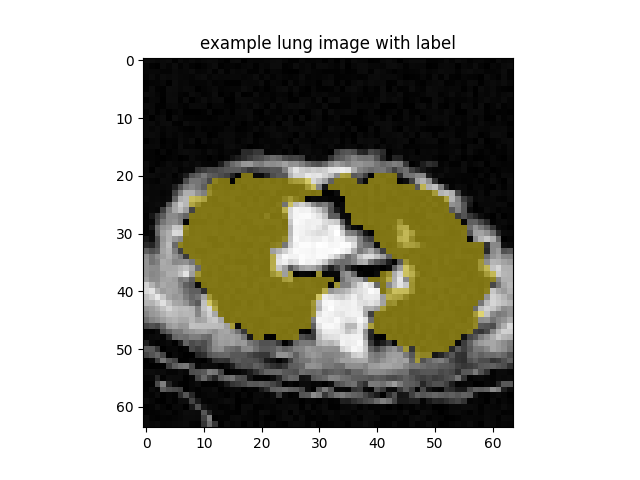

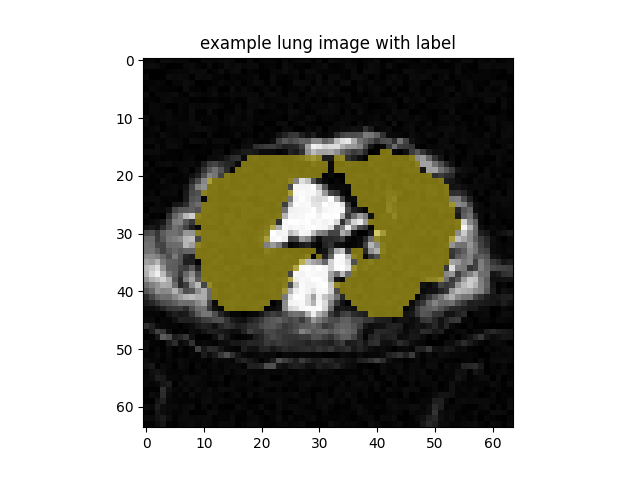

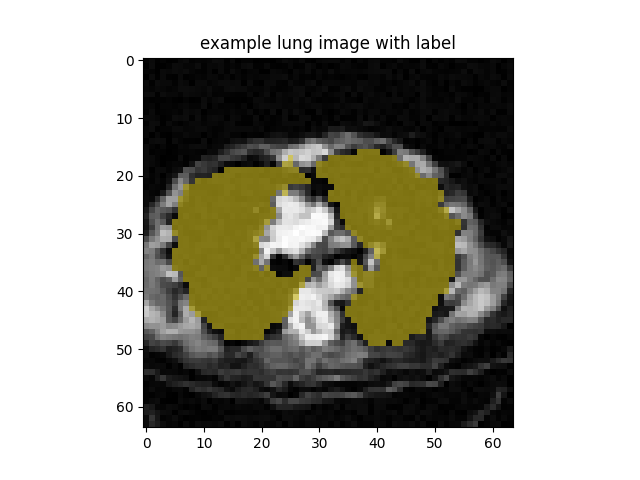

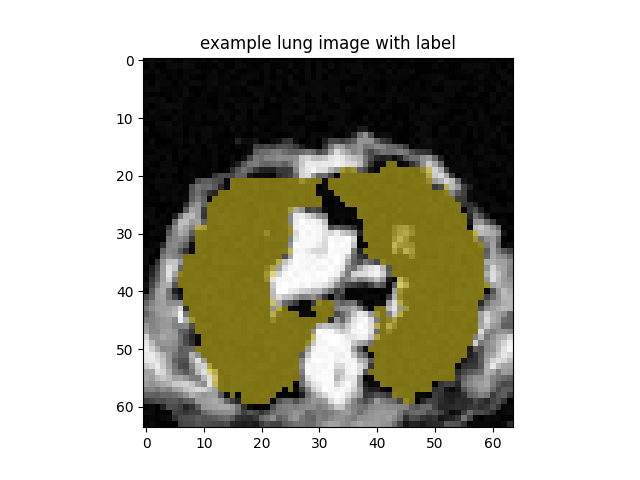

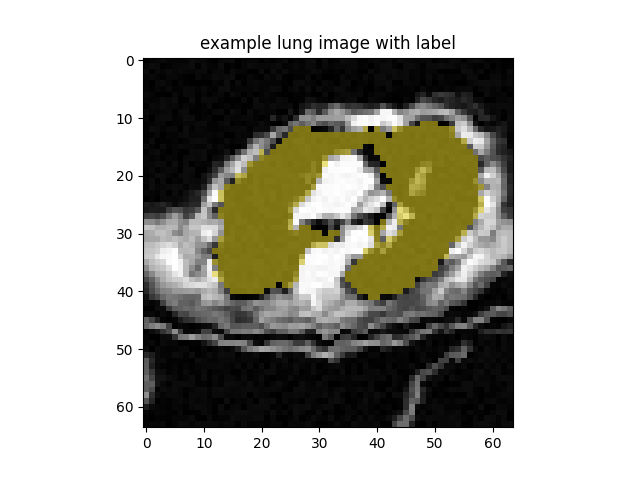

In [48]:
for i in range(5):
    I,l = dataset_lung_train_randomized[0]
    fig,ax = plt.subplots()
    ax.imshow(I[0],cmap='gray')
    ax.imshow(l[0],alpha=l[0]*0.5)
    ax.set_title('example lung image with label')

### Problem 3.1
Design at least two CNNs for segmenting the lung segmentation dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

You may (or may not) wish to make a new version of your randomization class, where you chose different parameters to generate realistic datasets.

In this dataset, flips and 90 degree rotations may (or may not) be useful, since all the images are already in a standard pose. You can investigate this in one of your training strategies if you want.

Train them on the training set (for however long you want), and test their Dice score and Hausdorff distance on the validation set.

Choose the best performing model on the validation set (using whatever criteria you'd like), and report its Haussdorf distance and Dice score on the test set.

I will rerun your notebook, and evaluate perforance in terms of Dice and Hausdorff on a random subset of the test set.  The random subset will be the same for all students.  2.5% of your grade (out of 100%) on this assignment will be based on your Dice score relative to the other students.  The student with the highest Dice will recieve 2.5%. The student with the lowest Dice will recieve 0%.  The others will vary linearly between these extremes.  

Another 2.5% of your grade (out of 100%) on this assignment will be based on your Hausdorff distance relative to the other students.  The student with the lowest distance will recieve 2.5%. The student with the highest distance will recieve 0%.  The others will vary linearly between these extremes.  

In [11]:
class SelfAttention(torch.nn.Module):
    def __init__(self,c=None):
        super().__init__()
        
        # a self attention layer will need to know the number of channels (feature maps)        
        if c is None:
            self.c = 64
        else:
            self.c = c
        
        
        # we will transform our imaging data to learn the important channels for computing similarities
        # here we use a "1x1" convolution.  This is just a matrix multiplication
        
        # first we'll two different linear combinations to look for similarity via dot product and softmax
        self.theta = torch.nn.Conv2d(self.c,self.c//2,1)
        self.phi = torch.nn.Conv2d(self.c,self.c//2,1)
        
        
        # now the data that we'll take a linear combination (weighted average) of
        self.g = torch.nn.Conv2d(self.c,self.c//2,1)
        
        
        # finally one last filter to get back to the right dimension
        self.z = torch.nn.Conv2d(self.c//2,self.c,1)
        
        
    def forward(self,x): 
        # save the original shape for later
        inshape = x.shape
        
        # compute theta and phi for computing similarity
        theta = self.theta(x)
        phi = self.phi(x)
        
        # unroll them into vectors instead of images
        theta = theta.reshape(x.shape[0],x.shape[1]//2,-1)
        phi = phi.reshape(x.shape[0],x.shape[1]//2,-1)        
        
        # take their "outer product" to get a matrix from two vectors
        # each element of the matrix is the dot product between feature maps at two pixels 
        # apply softmax on last dimension (the one that is summed over) so matrix multiplication will be a weighted average
        w = torch.softmax(theta[...,None]@phi[...,None,:],-1)
                        
        # get the signal to average, unroll it into a vector
        g = self.g(x)
        g = g.reshape(x.shape[0],x.shape[1]//2,-1)
        
        # multiply by the similarity matrix w
        # we use some "fancy indexing" so the matrix vector product is the right size
        wg = (w@g.reshape(x.shape[0],x.shape[1]//2,-1)[...,:,None])[...,0]
        
        
        # last transform back to an image (instead of a vector) and map to original number of channels
        z = self.z( wg.reshape(inshape[0],inshape[1]//2,inshape[2],inshape[3])  )
        
        # return with a skip connection
        return x + z


In [12]:
# now my model architecture
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 1
        self.chout = 2
        self.ch0 = 8
        self.stride = 2
        self.pad = 1
        self.ksize = 3
        
        # downsampling
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,self.ksize,1,self.pad)
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,self.ksize,self.stride,self.pad)
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,self.ksize,self.stride,self.pad)
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,self.ksize,self.stride,self.pad)
        
        # attention at the bottleneck
        self.a = SelfAttention()
        
        # upsampling
        self.ct3 = torch.nn.ConvTranspose2d(self.ch0*8,self.ch0*4,self.ksize,self.stride,self.pad,1)        
        self.ct2 = torch.nn.ConvTranspose2d(self.ch0*4*2,self.ch0*2,self.ksize,self.stride,self.pad,1)
        self.ct1 = torch.nn.ConvTranspose2d(self.ch0*2*2,self.ch0*1,self.ksize,self.stride,self.pad,1)
        self.ct0 = torch.nn.ConvTranspose2d(self.ch0*1*2,self.chout,self.ksize,1,self.pad)
    
    def forward(self,x):
        # downsampling
        stack = []
        x = torch.relu(self.c0(x))
        stack.append(x)
        
        x = torch.relu(self.c1(x))
        stack.append(x)
        
        x = torch.relu(self.c2(x))
        stack.append(x)
        
        x = torch.relu(self.c3(x))
        
        # here at the bottleneck we'll use attention
        x = torch.relu(self.a(x))
        
        # upsampling
        x = torch.relu(self.ct3(x))
        
        x = torch.concatenate((x,stack.pop()),-3)        
        x = torch.relu(self.ct2(x))
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = torch.relu(self.ct1(x))        
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = self.ct0(x)
        return x

In [13]:
loss = torch.nn.CrossEntropyLoss()
lr = 1e-3
model = Model()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
device = 'cuda:0'

In [ ]:
nepochs = 300

fig,ax = plt.subplots()
figI,axI = plt.subplots(1,3)
Esave = []
for e in range(nepochs):
    Esum = 0.0
    for x,l in dataloader_lung:
        optimizer.zero_grad()
        
        lhat = model(x)
        E = loss(lhat,l)
        E.backward()
        
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    with torch.no_grad():
        axI[0].cla()
        axI[0].imshow(x[0,0].cpu())
        
        axI[1].cla()
        axI[1].imshow(torch.softmax(lhat[0],0)[0].cpu(),vmin=0,vmax=1)
        
        axI[2].cla()
        axI[2].imshow(l[0,0].cpu(),vmin=0,vmax=1)
        
        figI.canvas.draw()

In [ ]:
torch.save(model.state_dict(),r"C:\Users\WINDOWS\Desktop\DSB207\segmentation1.pt")

In [24]:
model.load_state_dict(torch.load(r'C:\Users\WINDOWS\Desktop\DSB207\segmentation1.pt'))

<All keys matched successfully>

I wanted this to work but it crashed my laptop every time so I just adjusted the channel size instead

In [ ]:
# now my model architecture
class Model2_1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 1
        self.chout = 2
        self.ch0 = 2
        self.stride = 1
        self.pad = 2
        self.ksize = 3
        
        # downsampling
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,self.ksize,1,self.pad)
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,self.ksize,self.stride,self.pad)
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,self.ksize,self.stride,self.pad)
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,self.ksize,self.stride,self.pad)
        self.c4 = torch.nn.Conv2d(self.ch0*8,self.ch0*16,self.ksize,self.stride,self.pad)
        
        # attention at the bottleneck
        self.a = SelfAttention(self.ch0*16)
        
        # upsampling
        self.ct4 = torch.nn.ConvTranspose2d(self.ch0*16, self.ch0*8, self.ksize, self.stride, self.pad, 1)
        self.ct3 = torch.nn.ConvTranspose2d(self.ch0*8*2, self.ch0*4, self.ksize, self.stride, self.pad, 1)        
        self.ct2 = torch.nn.ConvTranspose2d(self.ch0*4*2,self.ch0*2,self.ksize,self.stride,self.pad,1)
        self.ct1 = torch.nn.ConvTranspose2d(self.ch0*2*2,self.ch0*1,self.ksize,self.stride,self.pad,1)
        self.ct0 = torch.nn.ConvTranspose2d(self.ch0*1*2,self.chout,self.ksize,1,self.pad)
    
    def forward(self,x):
        # downsampling
        stack = []
        x = torch.relu(self.c0(x))
        stack.append(x)
        
        x = torch.relu(self.c1(x))
        stack.append(x)
        
        x = torch.relu(self.c2(x))
        stack.append(x)
        
        x = torch.relu(self.c3(x))
        stack.append(x)
        
        x = torch.relu(self.c4(x))
        
        # here at the bottleneck we'll use attention
        x = torch.relu(self.a(x))
        
        # upsampling
        x = torch.relu(self.ct4(x))
        
        x = torch.concatenate((x,stack.pop()),-3) 
        x = torch.relu(self.ct3(x))
        
        x = torch.concatenate((x,stack.pop()),-3)        
        x = torch.relu(self.ct2(x))
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = torch.relu(self.ct1(x))        
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = self.ct0(x)
        return x

This would be considered my working custom one

In [17]:
# now my model architecture
class Model2_2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.chin = 1
        self.chout = 2
        self.ch0 = 16
        self.stride = 2
        self.pad = 1
        self.ksize = 3
        
        # downsampling
        self.c0 = torch.nn.Conv2d(self.chin,self.ch0,self.ksize,1,self.pad)
        self.c1 = torch.nn.Conv2d(self.ch0,self.ch0*2,self.ksize,self.stride,self.pad)
        self.c2 = torch.nn.Conv2d(self.ch0*2,self.ch0*4,self.ksize,self.stride,self.pad)
        self.c3 = torch.nn.Conv2d(self.ch0*4,self.ch0*8,self.ksize,self.stride,self.pad)
        
        # attention at the bottleneck
        self.a = SelfAttention(self.ch0*8)
        
        # upsampling
        self.ct3 = torch.nn.ConvTranspose2d(self.ch0*8,self.ch0*4,self.ksize,self.stride,self.pad,1)        
        self.ct2 = torch.nn.ConvTranspose2d(self.ch0*4*2,self.ch0*2,self.ksize,self.stride,self.pad,1)
        self.ct1 = torch.nn.ConvTranspose2d(self.ch0*2*2,self.ch0*1,self.ksize,self.stride,self.pad,1)
        self.ct0 = torch.nn.ConvTranspose2d(self.ch0*1*2,self.chout,self.ksize,1,self.pad)
    
    def forward(self,x):
        # downsampling
        stack = []
        x = torch.relu(self.c0(x))
        stack.append(x)
        
        x = torch.relu(self.c1(x))
        stack.append(x)
        
        x = torch.relu(self.c2(x))
        stack.append(x)
        
        x = torch.relu(self.c3(x))
        
        # here at the bottleneck we'll use attention
        x = torch.relu(self.a(x))
        
        # upsampling
        x = torch.relu(self.ct3(x))
        
        x = torch.concatenate((x,stack.pop()),-3)        
        x = torch.relu(self.ct2(x))
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = torch.relu(self.ct1(x))        
        
        x = torch.concatenate((x,stack.pop()),-3)
        x = self.ct0(x)
        return x

In [18]:
model2 = Model2_2()
optimizer = torch.optim.Adam(model2.parameters(),lr=lr)

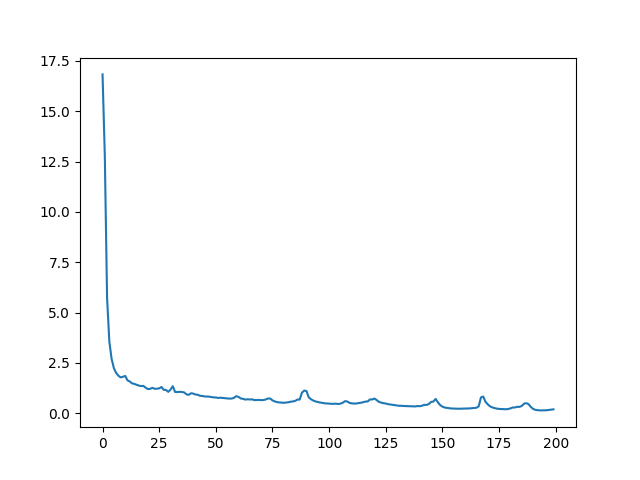

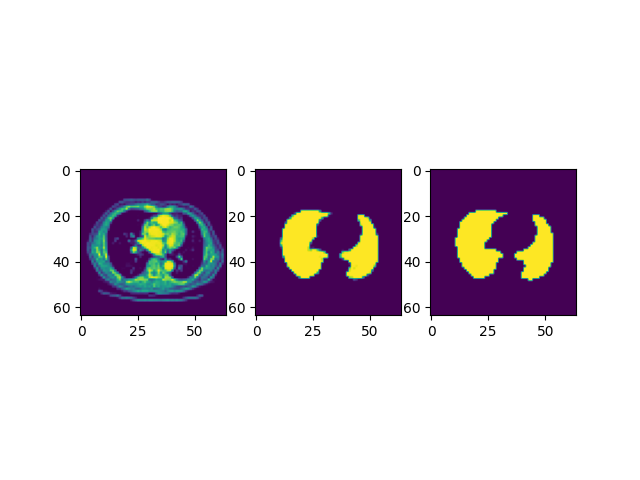

In [19]:
nepochs = 200

fig,ax = plt.subplots()
figI,axI = plt.subplots(1,3)
Esave = []
for e in range(nepochs):
    Esum = 0.0
    for x,l in dataloader_lung:
        optimizer.zero_grad()
        
        lhat = model2(x)
        E = loss(lhat,l)
        E.backward()
        
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()
    
    with torch.no_grad():
        axI[0].cla()
        axI[0].imshow(x[0,0].cpu())
        
        axI[1].cla()
        axI[1].imshow(torch.softmax(lhat[0],0)[0].cpu(),vmin=0,vmax=1)
        
        axI[2].cla()
        axI[2].imshow(l[0,0].cpu(),vmin=0,vmax=1)
        
        figI.canvas.draw()

In [20]:
def get_boundary(lhat_):
    # if it is a tensor, convert it to a numpy array
    if isinstance(lhat_,torch.Tensor):
        lhat_ = lhat_.clone().detach().cpu().numpy()
    
    # get boundary pixels by checking that a pixel value is not equal to its neighbor
    bhat = (lhat_[:,0] != np.roll(lhat_[:,0],shift=1,axis=-1)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=-1,axis=-1)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=1,axis=-2)) 
    bhat = bhat +  (lhat_[:,0] != np.roll(lhat_[:,0],shift=-1,axis=-2)) 
    bhat = bhat >= 1
    # make sure we only include the "inside" boundary, and not the "outside"
    bhat = (bhat * lhat_[:,0]) >= 1
    
        
    return bhat

In [21]:
torch.save(model2.state_dict(),r"C:\Users\WINDOWS\Desktop\DSB207\segmentation2.pt")

In [ ]:
model2.load_state_dict(torch.load('mC:\Users\WINDOWS\Desktop\DSB207\segmentation2.pt'))

In [25]:
def hausdorff(l,lhat_,show=False):    
    # get the boundary pixels
    bhat = get_boundary(lhat_)
    b = get_boundary(l)
    if show:
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(lhat_[-1,0]*1.0 - l[-1,0]*1.0)
        ax[1].imshow(bhat[-1]*1.0 - b[-1]*1.0)
    # get the pixel locations
    x0 = np.arange(b.shape[-2])
    x1 = np.arange(b.shape[-1])    
    X = np.stack(np.meshgrid(x0,x1,indexing='ij'),-1)
    
    # loop over a minibatch
    h = []
    for i in range(l.shape[0]):
        x = X[b[i]]
        xhat = X[bhat[i]]
        # get pairwize distances in a 2D matrix, using "fancy indexing"
        d2 = np.sum( (x[:,None] - xhat[None,:])**2 , -1)
        # find the minima over each axis.  This gives the "closest pixel"
        d2m0 = np.min(d2,0)
        d2m1 = np.min(d2,1)
        # take the maximum over all these minimums
        d2m = np.concatenate((d2m0,d2m1))
        d2M = np.max(d2m)
        # append it into our minibatch
        h.append(np.sqrt(d2M))       
    return h

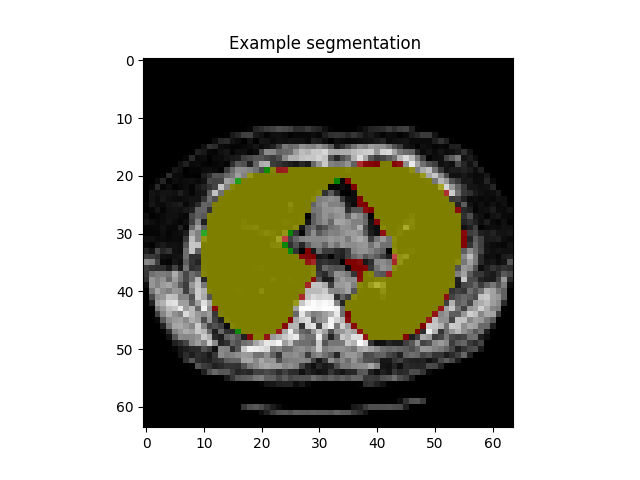

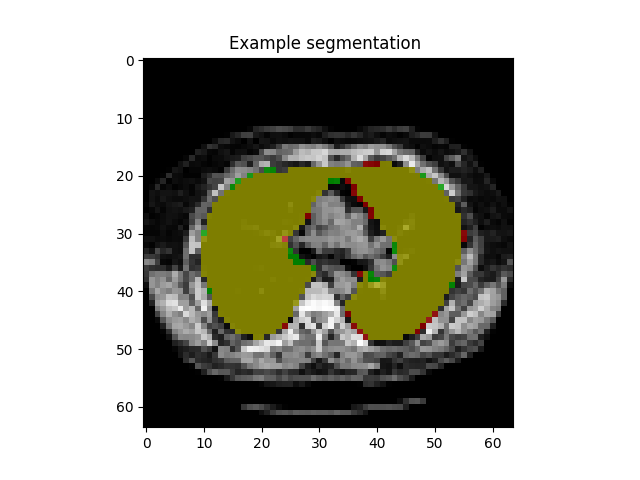

In [26]:
# compute our metrics here
dice_deep1 = []
iou_deep1 = []
h_deep1 = []
fig,ax = plt.subplots()
with torch.no_grad():
    for x,l in dataloader_test:
        # get the prediction
        lhat = torch.softmax( model(x) , 1)
        
        # binarize it
        lhat_ = lhat>0.5
        
        # we can use "times" to compute the intersection
        intersection = torch.sum(lhat_[:,0]*l[:,0],dim=(-1,-2))
        # we can use "plus" to compute the union
        union = torch.sum( (lhat_[:,0]+l[:,0])>=1  , dim=(-1,-2))
        # find the average volume for dice score
        avg = (torch.sum(lhat_[:,0],dim=(-1,-2))  + torch.sum(l[:,0],dim=(-1,-2)) )/2
        
        # distance betwen boundaries
        h_deep1.extend( hausdorff(l,lhat_) )
        
        # dice score
        dice_deep1.extend(  intersection/avg )
        # iou
        iou_deep1.extend(  intersection/union )
        
    ax.imshow(x[-1,0],cmap='gray')
    ax.imshow(torch.stack( (lhat_[-1,0], l[-1,0], l[-1,0]*0, ( (lhat_[-1,0]+l[-1,0])>=1)*1.0*0.5  ), -1 ) )
    ax.set_title('Example segmentation ')    
    
    # compute our metrics here
dice_deep2 = []
iou_deep2 = []
h_deep2 = []
fig,ax = plt.subplots()
with torch.no_grad():
    for x,l in dataloader_test:
        # get the prediction
        lhat = torch.softmax( model2(x) , 1)
        
        # binarize it
        lhat_ = lhat>0.5
        
        # we can use "times" to compute the intersection
        intersection = torch.sum(lhat_[:,0]*l[:,0],dim=(-1,-2))
        # we can use "plus" to compute the union
        union = torch.sum( (lhat_[:,0]+l[:,0])>=1  , dim=(-1,-2))
        # find the average volume for dice score
        avg = (torch.sum(lhat_[:,0],dim=(-1,-2))  + torch.sum(l[:,0],dim=(-1,-2)) )/2
        
        # distance betwen boundaries
        h_deep2.extend( hausdorff(l,lhat_) )
        
        # dice score
        dice_deep2.extend(  intersection/avg )
        # iou
        iou_deep2.extend(  intersection/union )
        
    ax.imshow(x[-1,0],cmap='gray')
    ax.imshow(torch.stack( (lhat_[-1,0], l[-1,0], l[-1,0]*0, ( (lhat_[-1,0]+l[-1,0])>=1)*1.0*0.5  ), -1 ) )
    ax.set_title('Example segmentation ') 
        

In [28]:
print("model 1")
print(torch.mean(torch.stack(dice_deep1)))
print(np.mean(np.stack(h_deep1)))
print("model 2")
print(torch.mean(torch.stack(dice_deep2)))
print(np.mean(np.stack(h_deep2)))

model 1
tensor(0.9686)
2.7035792690446914
model 2
tensor(0.9644)
3.002093924550331


My best is the first model with a score of 0.9686 dice score and a 2.70 Hausdorff distance


## Part 4, the MEDMNIST paper

Read the paper, MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification, shared on the course website.

### Problem 4.1

Why was this family of datasets developed?

This family of datasets were developed in order to perform classification on lightweight 2D and 3D images, giving a data set that is diverse, standardized, lightweight, and educational.

### Problem 4.2

For the DermaMNIST dataset, describe the medical problem that machine learning techniques could be used to solve or automate.

The DermaMNIST data set can help with identifying different skin lesions for improved diagnoses, because there are so many different types.  If not it could at least help narrow down the skin lesions identification to wehter or not it may indicate something worse such as skin cancer.

## Part 5, The Unet-Paper

Read the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation, shared on the course website.

### Problem 5.1

What task was the unet developed to solve?

UNET was developed to solve the task of classifcation of image segments and improving on the limitations of the deep convolutional networks.  Allowing for class labels assigned to pixels rather than jus thte image, which is better for biomedical tasks.

### Problem 5.2
Describe 2 ways in which the model architecture presented in this paper differed from the basic unet model we discussed in class (note you can find more than two differences).

In our model, we have a padding of 1 while theirs have 0.  We also go down 3 before the bottle neck step and the one in the paper goes down four before the bottle neck step. 

### Problem 5.3
Describe how the cross entropy loss function presented in the paper different from the one defined in class?

The cross entropy loss function presented in the paper is not negative while our's is and in the paper it uses w(x) which is a weighted map while we use delta which is just a binary between 1 and 0.